
## Using Clustering first and then PCA for visualization


Optimal Number of Clusters: 4
DB Index for Optimal Clusters: 0.8821991487279204


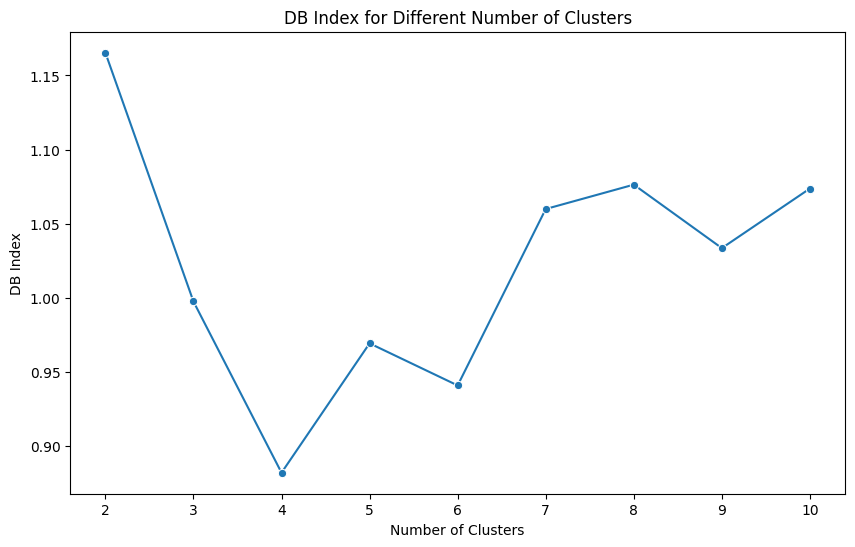

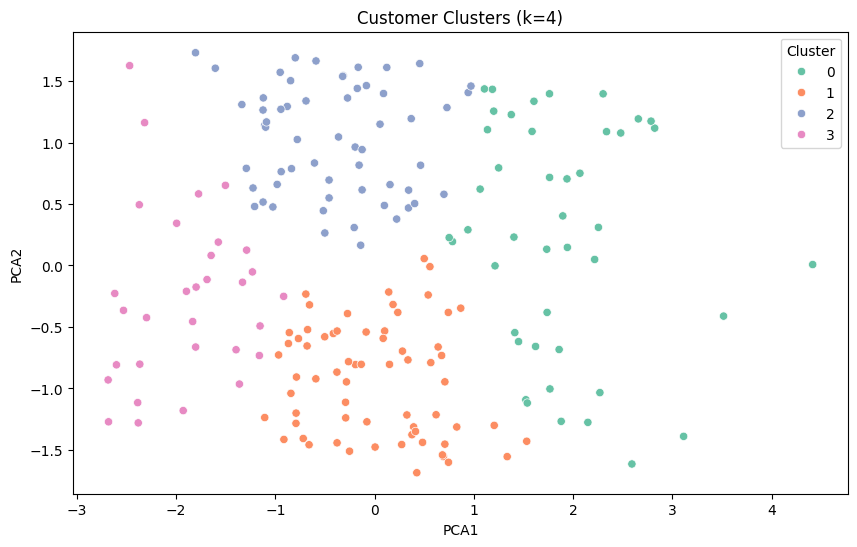

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


#Only two datasets in use this time.
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

merged_df = transactions.merge(customers, on='CustomerID', how='left')

merged_df['SignupDuration'] = (pd.to_datetime('2025-01-01') - pd.to_datetime(merged_df['SignupDate'])).dt.days
customer_features = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Number of transactions
    'SignupDuration': 'max',  # Customer tenure
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionCount'
}).reset_index()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))

db_index_scores = []
cluster_results = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_index_scores.append(db_index)
    cluster_results[k] = (kmeans, cluster_labels, db_index)

# Select optimal number of clusters (minimize DB Index)
optimal_clusters = min(db_index_scores, key=lambda x: x)
optimal_k = db_index_scores.index(optimal_clusters) + 2

print(f"Optimal Number of Clusters: {optimal_k}")
print(f"DB Index for Optimal Clusters: {optimal_clusters}")

#Plotting DB indexes for different number of clusters
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(2, 11), y=db_index_scores, marker='o')
plt.title('DB Index for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# Assign optimal clustering results
_ , cluster_labels, _ = cluster_results[optimal_k]
customer_features['Cluster'] = cluster_labels

# Visualize Clusters (using PCA for dimensionality reduction)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
customer_features['PCA1'] = pca_features[:, 0]
customer_features['PCA2'] = pca_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title(f'Customer Clusters (k={optimal_k})')
plt.show()

customer_features.to_csv('Customer_Segments.csv', index=False)


In [6]:
silhouette_scores = []
db_index_scores = []
cluster_results = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Calculate DB Index
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_index_scores.append(db_index)

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    cluster_results[k] = (kmeans, cluster_labels, db_index, silhouette_avg)

optimal_clusters_db = min(db_index_scores, key=lambda x: x)
optimal_k_db = db_index_scores.index(optimal_clusters_db) + 2

optimal_clusters_sil = max(silhouette_scores)
optimal_k_sil = silhouette_scores.index(optimal_clusters_sil) + 2

print(f"Optimal Clusters (DB Index): {optimal_k_db} with DB Index: {optimal_clusters_db}")
print(f"Optimal Clusters (Silhouette Score): {optimal_k_sil} with Silhouette Score: {optimal_clusters_sil}")


Optimal Clusters (DB Index): 4 with DB Index: 0.8821991487279204
Optimal Clusters (Silhouette Score): 4 with Silhouette Score: 0.35014616809371946


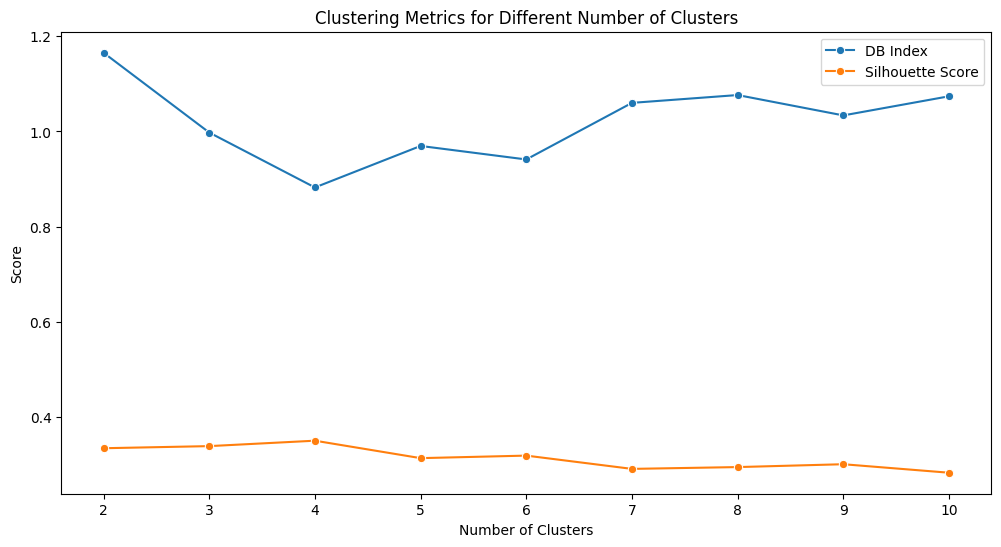

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(2, 11), y=db_index_scores, marker='o', label='DB Index')
sns.lineplot(x=range(2, 11), y=silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Clustering Metrics for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()



## Using PCA first for reduction and then clustering


Optimal Number of Clusters: 7
DB Index for Optimal Clusters: 0.7595072196841476


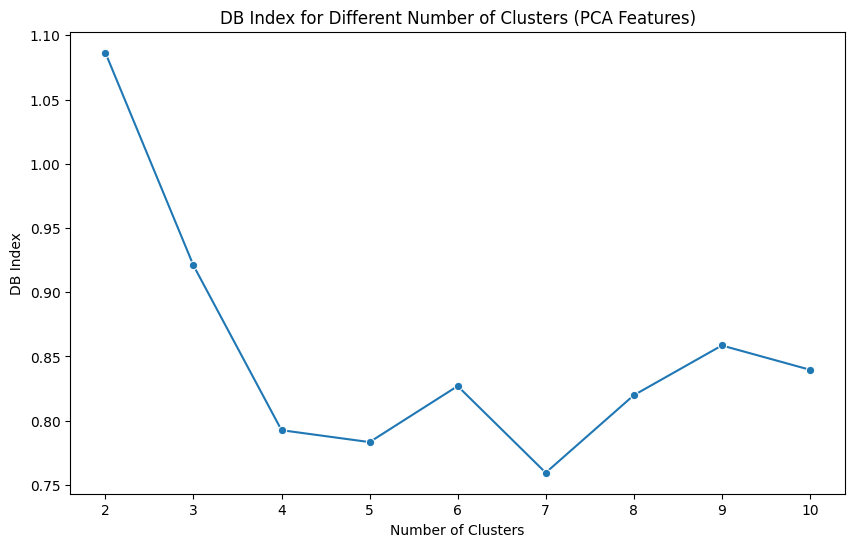

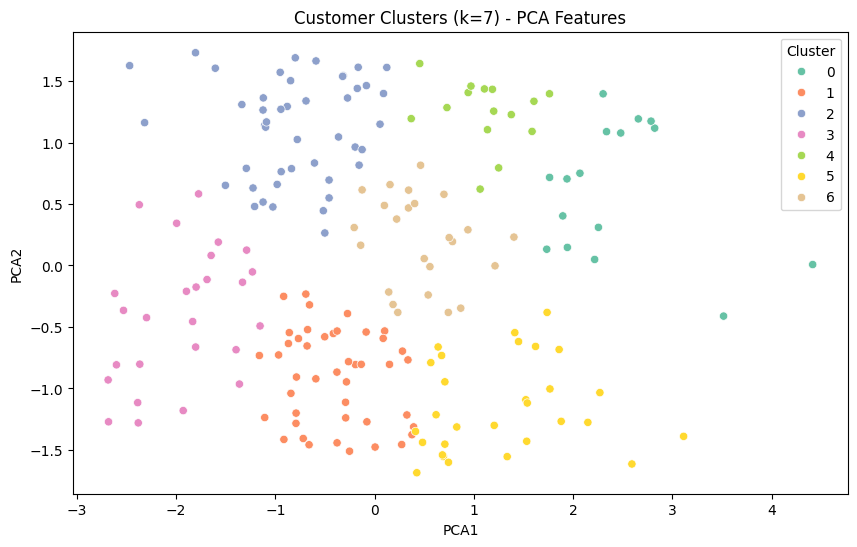

In [8]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

merged_df = transactions.merge(customers, on='CustomerID', how='left')

merged_df['SignupDuration'] = (pd.to_datetime('2025-01-01') - pd.to_datetime(merged_df['SignupDate'])).dt.days
customer_features = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Number of transactions
    'SignupDuration': 'max',  # Customer tenure
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionCount'
}).reset_index()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_features = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(pca_features, columns=['PCA1', 'PCA2'])
pca_df['CustomerID'] = customer_features['CustomerID']

# Perform Clustering on PCA Features
db_index_scores = []
cluster_results = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_features)
    db_index = davies_bouldin_score(pca_features, cluster_labels)
    db_index_scores.append(db_index)
    cluster_results[k] = (kmeans, cluster_labels, db_index)

# Select optimal number of clusters (minimize DB Index)
optimal_clusters = min(db_index_scores, key=lambda x: x)
optimal_k = db_index_scores.index(optimal_clusters) + 2

print(f"Optimal Number of Clusters: {optimal_k}")
print(f"DB Index for Optimal Clusters: {optimal_clusters}")

# Plot DB Index scores
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(2, 11), y=db_index_scores, marker='o')
plt.title('DB Index for Different Number of Clusters (PCA Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# Assigning Clustering Results
_, cluster_labels, _ = cluster_results[optimal_k]
pca_df['Cluster'] = cluster_labels

# Visualizing Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title(f'Customer Clusters (k={optimal_k}) - PCA Features')
plt.show()

pca_df.to_csv('Customer_Segments_PCA_Clusters.csv', index=False)
